### Imports

In [1]:
import pandas as pd
import numpy as np

import os, sys

import plotly
import plotly.express as px

# change the default renderer so it shows on something like Github
plotly.io.renderers.default = 'png'

#add my own file with custom utility functions as a module
utils_path = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir)))
if utils_path not in sys.path:
    sys.path.append(utils_path)

import aku_utils as ak

# pandas options
pd.options.display.max_columns = 100
pd.options.display.max_rows =  200
# pd.options.display.max_info_rows = 1690785
pd.options.display.max_info_columns = 200
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.date_dayfirst = True
pd.options.mode.chained_assignment = None

### Data overview

In [2]:
df = pd.read_csv(os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'telco_processed.csv'))))
df.head()

,gender,age,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,population,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,churn,ibm_spss_churn_prob,cltv,churn_category,churn_reason,new_customer
0,1,78,0,0,0,Los Angeles,90022,34.02,-118.16,68701,0,0,1,NaN,0,0.00,0,1,DSL,8,0,0,1,0,0,1,0,0,Month-to-Month,1,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,3,1,91,5433,Competitor,Competitor offered more data,0
1,0,74,1,1,1,Los Angeles,90063,34.04,-118.19,55668,1,1,8,Offer E,1,48.85,1,1,Fiber Optic,17,0,1,0,0,0,0,0,1,Month-to-Month,1,Credit Card,80.65,633.30,0.00,0,390.80,"1,024.10",3,1,69,5302,Competitor,Competitor made better offer,0
2,1,71,0,1,3,Los Angeles,90065,34.11,-118.23,47534,0,0,18,Offer D,1,11.33,1,1,Fiber Optic,52,0,0,0,0,1,1,1,1,Month-to-Month,1,Bank Withdrawal,95.45,"1,752.55",45.61,0,203.94,"1,910.88",2,1,81,3179,Competitor,Competitor made better offer,0
3,0,78,1,1,1,Inglewood,90303,33.94,-118.33,27778,1,1,25,Offer C,1,19.76,0,1,Fiber Optic,12,0,1,1,0,1,1,0,1,Month-to-Month,1,Bank Withdrawal,98.50,"2,514.50",13.43,0,494.00,"2,995.07",2,1,88,5337,Dissatisfaction,Limited range of services,0
4,0,80,1,1,1,Whittier,90602,33.97,-118.02,26265,1,1,37,Offer C,1,6.33,1,1,Fiber Optic,14,0,0,0,0,0,0,0,1,Month-to-Month,1,Bank Withdrawal,76.50,"2,868.15",0.00,0,234.21,"3,102.36",2,1,67,2793,Price,Extra data charges,0


# EDA

### Client portrait

First of all, let's explore what kind of people are using our services

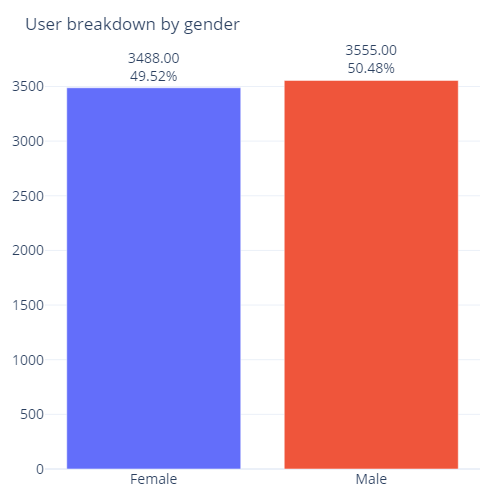

In [3]:
out = df.groupby('gender', as_index=False).size().replace({0 : 'Female', 1 : 'Male'})
ak.plot.bar(out, title='User breakdown by gender')

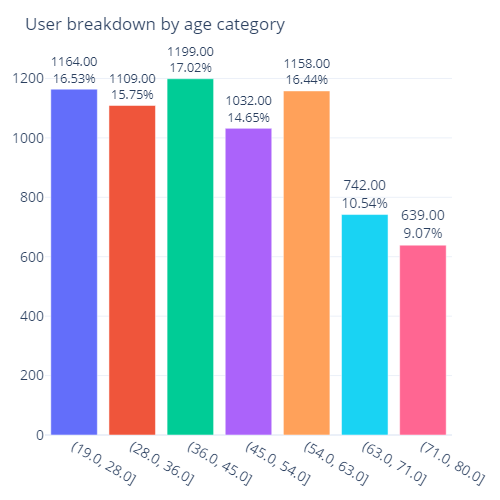

In [4]:
df['age_bin'], age_bins = pd.cut(df['age'], 7, precision=0, retbins=True)
df['age_bin'] = df['age_bin'].astype('str')

out = df.groupby('age_bin', as_index=False).size()
user_age = ak.plot.bar(out, title='User breakdown by age category')
user_age

It would be nice to compare our customer age breakdown with state age breakdown to see if some specific age groups are interested in our services or we undertarget these demographic groups.

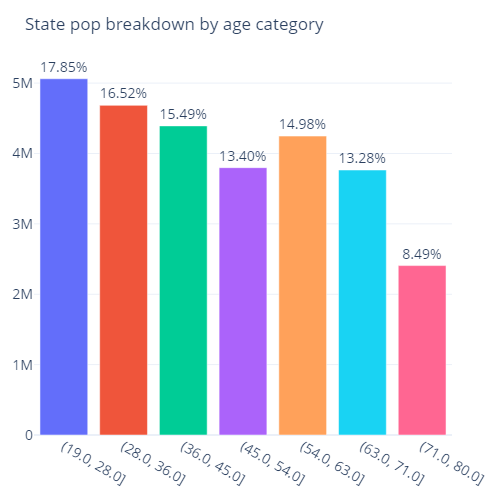

In [5]:
cali_pop = pd.read_excel(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'P1B_State_Age.xlsx'), sheet_name='State Population by Age', skiprows=2)
cali_pop = cali_pop[['Population', '2022']].rename({'Population' : 'age', '2022' : 'pop'}, axis=1)
cali_pop['age'] = pd.to_numeric(cali_pop['age'], errors='coerce')
cali_pop = cali_pop[(cali_pop['age'] > 18) & (cali_pop['age'] < 81)]
cali_pop['age_bin'] = pd.cut(cali_pop['age'], bins=age_bins, precision=0).astype('str')
cali_pop = cali_pop.drop('age', axis=1)

out = cali_pop.groupby('age_bin', as_index=False)['pop'].sum()
state_age = ak.plot.bar(out, display_values=False, title='State pop breakdown by age category')
state_age

We see no signicant changes between customer and state population age: people of age 28-63 are slightly more prevalent in our customer base, but it's nothing significant.

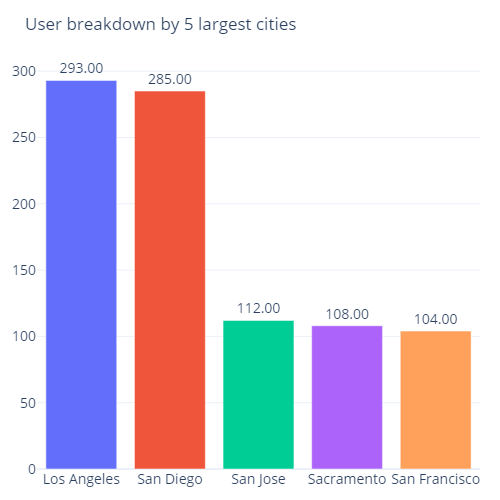

In [6]:
out = df.groupby('city', as_index=False).size().nlargest(5, 'size')
ak.plot.bar(out, title='User breakdown by 5 largest cities', display_pct=False)

This result also coincides with state's largest cities, so no anomalies here.

Let's see if a ZIP code coincides with exactly one latitude-longitude position. To prove it, we calculate variation of latitude and longitude grouped by the ZIP:

In [7]:
df.groupby('zip_code').agg({'latitude' : 'std', 'longitude' : 'std'}).sum()

latitude    0.00
longitude   0.00
dtype: float64

As you can see, the standard deviation (for all ZIPs) is zero, which proves our hypothesis. So, we can group our customers by latitude and longitude to see what exact areas are our customers from, which allows us to not rely on bar plots, which can only give partial information.

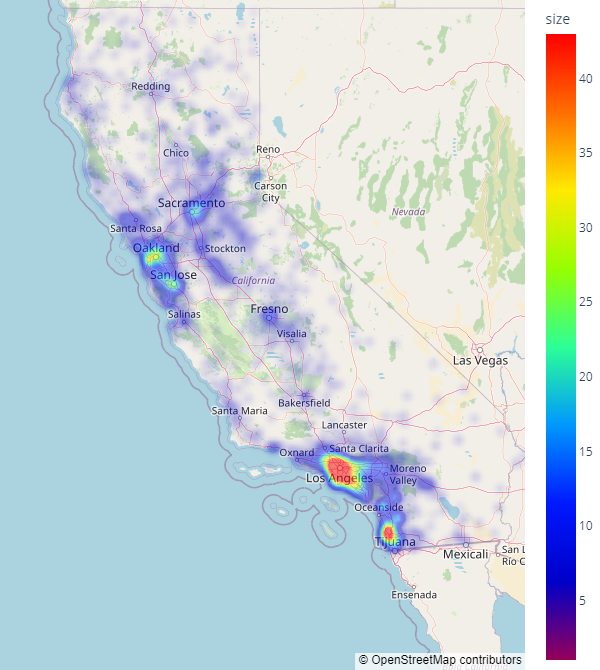

In [8]:
fig = px.density_mapbox(df.groupby(['latitude', 'longitude'], as_index=False).size(),
                        lat = 'latitude', lon = 'longitude', z = 'size',
                        radius = 12, zoom = 5, opacity = 0.5, color_continuous_scale='rainbow', mapbox_style = 'open-street-map'
                        )

fig.update_layout(ak.plot.default_map_layout, width=600, height=670)

fig.show()

We can see that, although our customer base is concentrated in a couple of the biggest cities in the state, they can be found anywhere in the state, even in the eastern part, which is largely considered a desert.

Lets continue with customer portrait to see if we can pick up any other insights.

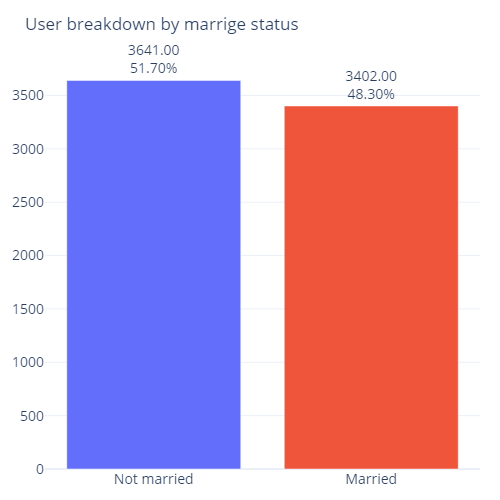

In [9]:
out = df.groupby('married', as_index=False).size().replace({0 : 'Not married', 1 : 'Married'})
ak.plot.bar(out, title='User breakdown by marrige status')

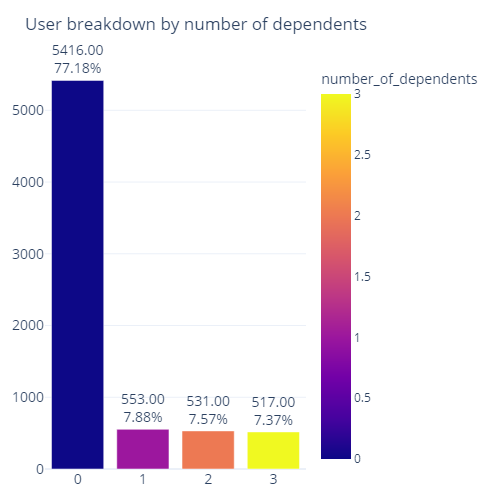

In [10]:
out = df.groupby('number_of_dependents', as_index=False).size()[:4]
ak.plot.bar(out, title='User breakdown by number of dependents')

These columns did not yield anything insights - everything looks normal.

##### Insights about customer base:

* Our customers are concentrated in larger cities of the state, specifically Los Angeles and San Diego
* They are, however, found throughout the whole state, which means that we, at the very least, have coverage in these places. It would be nice to see how the customer satisfaction and churn depends in these places compared to large cities
* The ages from 28 to 63 are slightly more prevalent in our customer base than state population, which, on one side, is to be expected given the services we offer, but, on the other side, we might be undertargeting the category of young adults, aged 21-28.

### How the clients are using our services

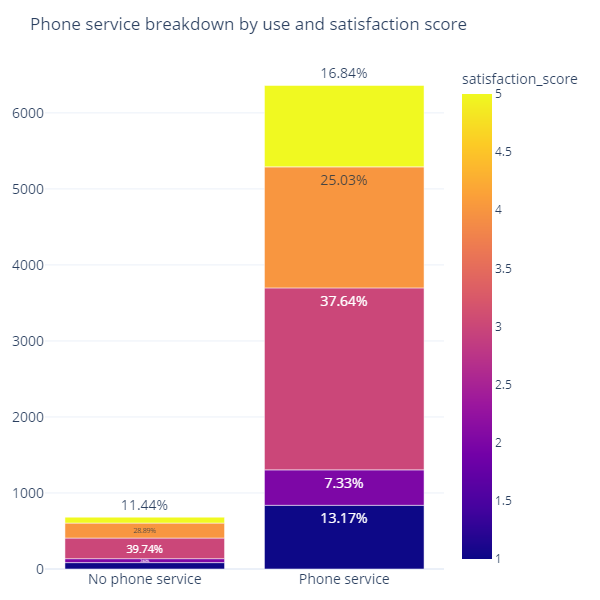

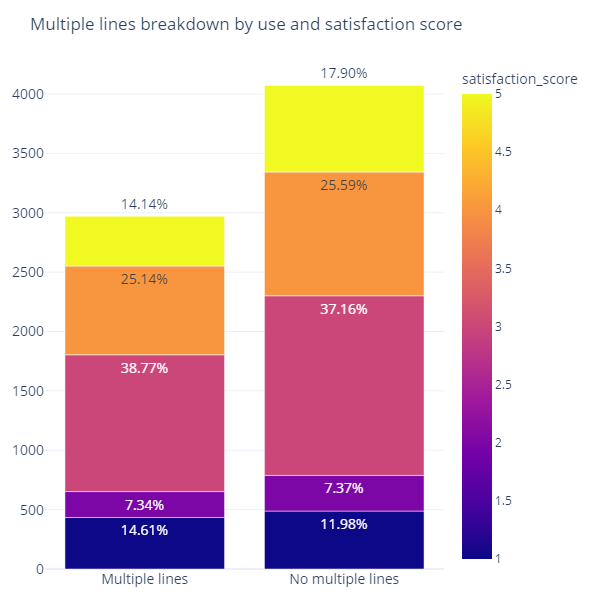

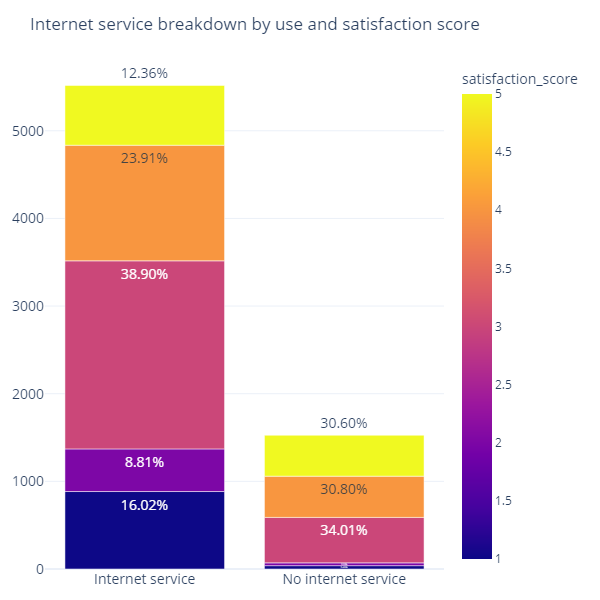

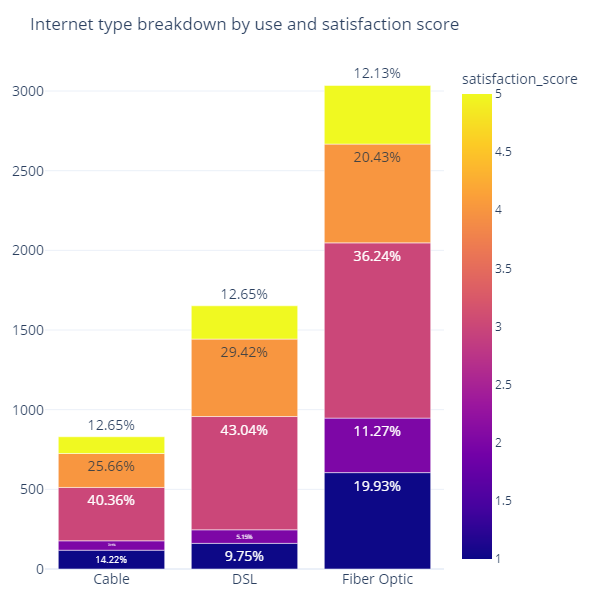

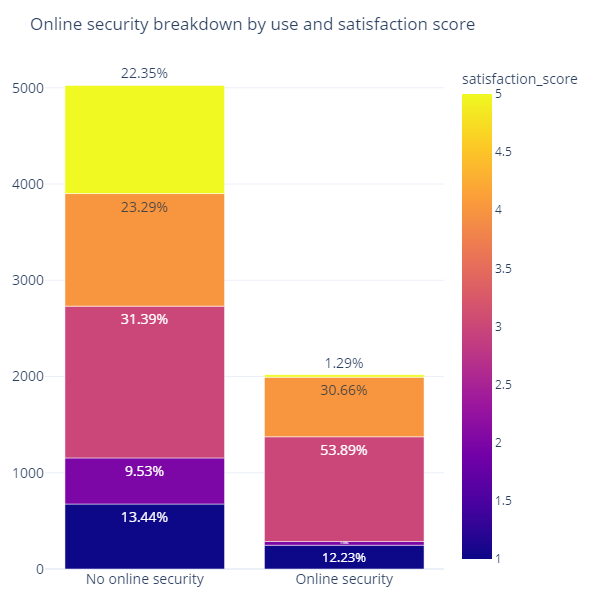

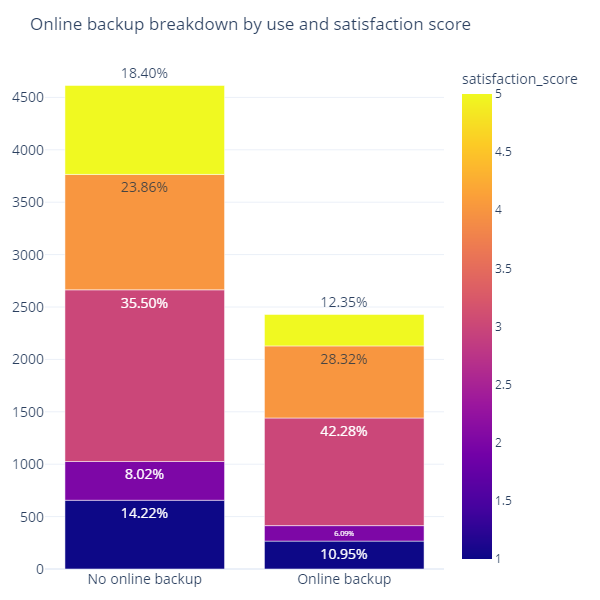

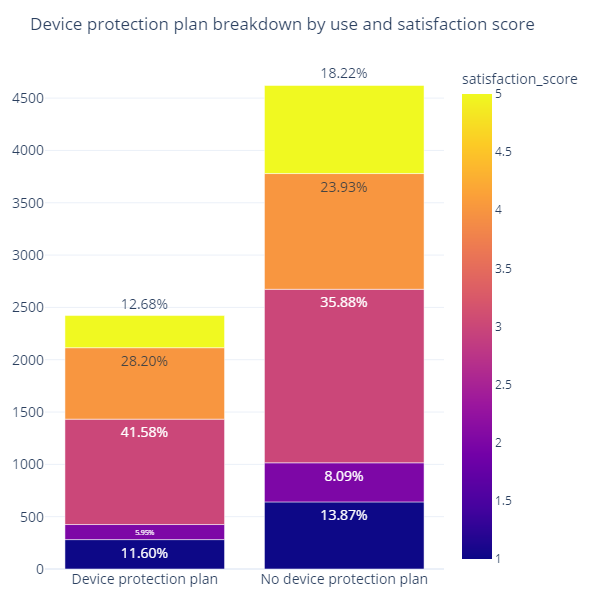

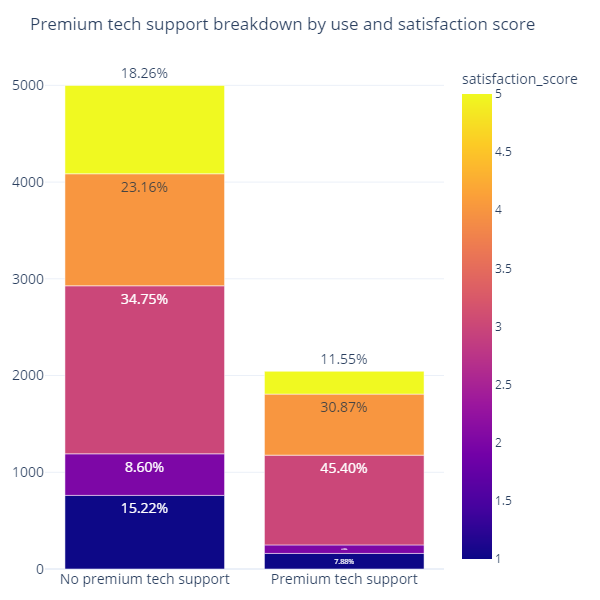

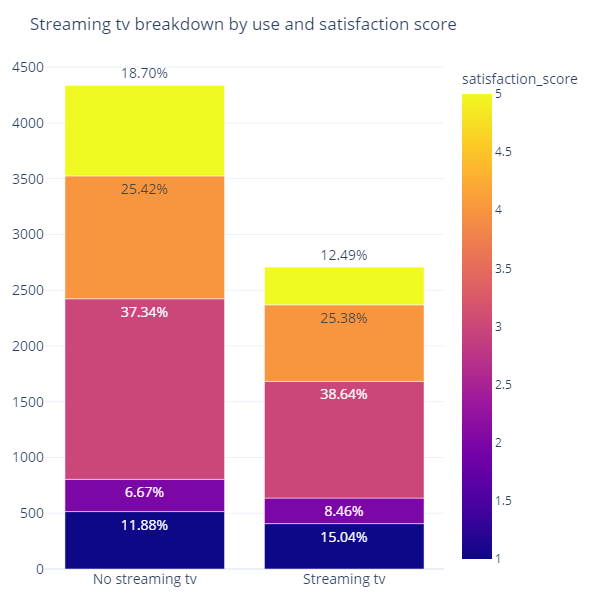

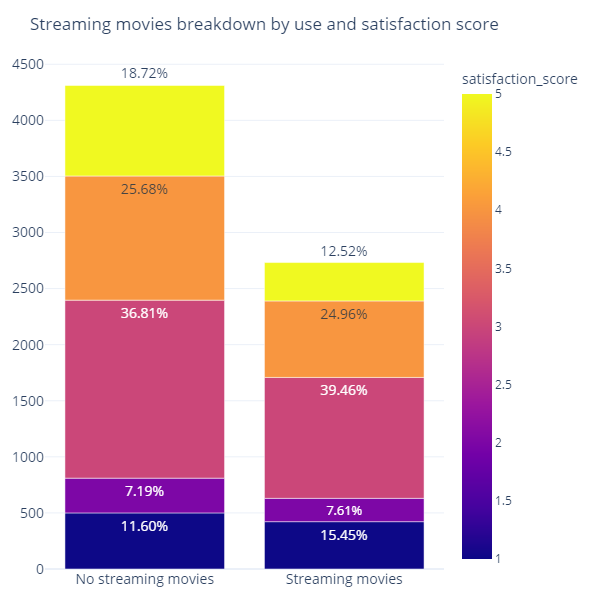

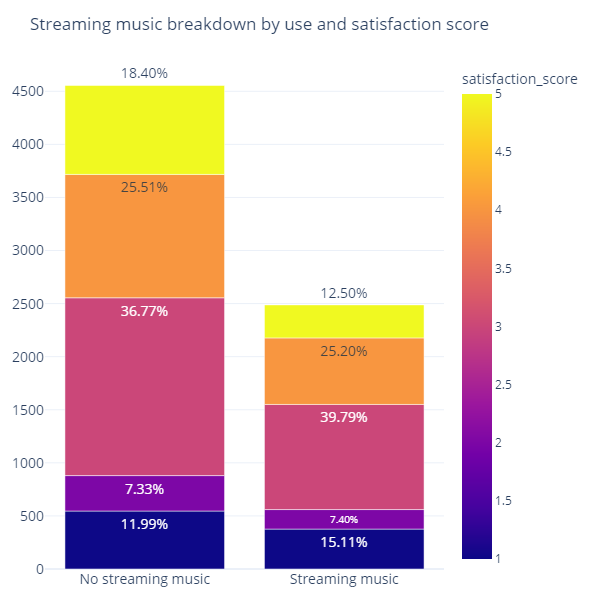

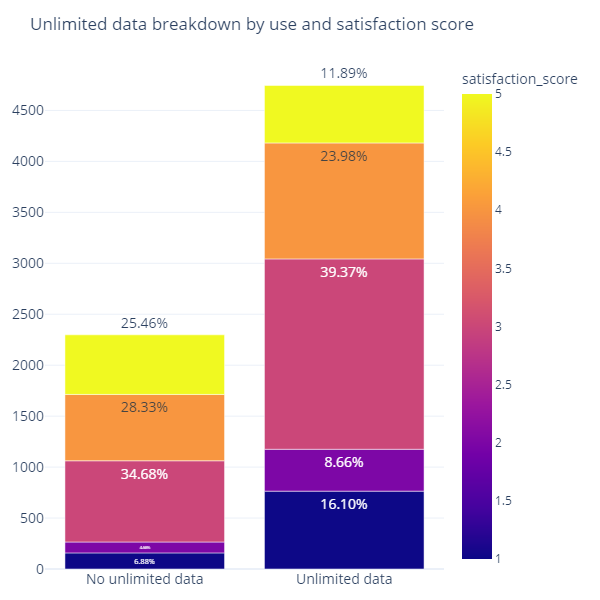

In [11]:
services_list = ['phone_service', 'multiple_lines', 'internet_service', 'internet_type',
                 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support',
                 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']

for service in services_list:
    srs = ak.humanize_srs(df[service])

    out = pd.concat([srs, df['satisfaction_score']], axis=1).groupby([srs.name, 'satisfaction_score'], as_index=False).size()

    fig = ak.plot.bar(out, title=f'{srs.name.capitalize()} breakdown by use and satisfaction score',
                      display_values=False)
    fig.update_layout(width=600, height=600)
    fig.show()

### Churn analysis

How are clients using our services:

Breakdown by service, service type

Sankey of service and its type\
\
Churn:
overall churn, churn by city or location (%: churned / all), % of churn by churn category,

score 1 by category, create a series with score 1 having 1 new score, 2 score having 2, 1 having 4. Plot this new dissatisfaction score

dissatisfaction by service, churn by service

sat. score histogram 1) total for comparison 2) by service 3) by internet service\
\
Association rule mining? Preferrably on churn


